# **Assignment 3: Google Play Store Rating Prediction**
# **Name:** Mingyue Liu

# ---
#  **Part 1: Mount Google Drive**
### Mount Google Drive to access data files

In [25]:
from google.colab import files
uploaded = files.upload()

Saving googleplaystore.csv to googleplaystore (1).csv


# ---
# **Part 2: Data Preprocessing & Feature Engineering**
## **Step 1: Load Data**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("googleplaystore.csv")
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
df.to_csv("processed_data.csv", index=False)

### **Load Raw Data**

In [27]:
df = pd.read_csv("processed_data.csv")
print(df.head())

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend 

### **Data Cleaning**

In [28]:
df = df.dropna(subset=["Rating"]).copy()


df["Size"] = df["Size"].replace("Varies with device", np.nan)
df["Size"] = df["Size"].astype(str).str.replace("M", "", regex=False).str.replace("k", "e3", regex=False)
df["Size"] = df["Size"].str.replace("[+,]", "", regex=True)


df["Size"] = pd.to_numeric(df["Size"], errors="coerce")
df["Size"] = df["Size"].fillna(df["Size"].median())


df["Installs"] = df["Installs"].astype(str).str.replace("[+,]", "", regex=True).replace("Free", "0")
df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce").fillna(0)


df["Price"] = df["Price"].astype(str).str.replace("$", "", regex=False)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce").fillna(0)


df["Reviews"] = df["Reviews"].astype(str).str.replace(",", "", regex=False)
df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce").fillna(0)

### **Feature Engineering**

In [29]:
df["Engagement Score"] = (df["Installs"] * df["Reviews"]) / (df["Size"] + 1)
df["Price per Review"] = df["Price"] / (df["Reviews"] + 1)
df["Is_High_Rated"] = (df["Rating"] >= 4.5).astype(int)

### **Feature Scaling**

In [30]:
scaler = StandardScaler()
df[["Size", "Price", "Installs", "Reviews"]] = scaler.fit_transform(df[["Size", "Price", "Installs", "Reviews"]])

### **Categorical Encoding**

In [31]:
encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(df[["Category"]])
df_encoded = pd.DataFrame(category_encoded, columns=encoder.get_feature_names_out(["Category"]))
df = pd.concat([df, df_encoded], axis=1).drop(columns=["Category"])

### **PCA Dimensionality Reduction**

In [32]:
category_features = df.filter(like="Category_")
if not category_features.empty:
    category_features = category_features.fillna(0)
    if category_features.shape[1] > 1:
        pca = PCA(n_components=min(5, category_features.shape[1]))
        category_pca = pca.fit_transform(category_features)
        df_pca = pd.DataFrame(category_pca, columns=[f"PCA_{i}" for i in range(1, min(5, category_features.shape[1]) + 1)])
        df = df.drop(columns=category_features.columns)
        df = pd.concat([df, df_pca], axis=1)

### **Save Processed Data**

In [33]:
data_path = "processed_data.csv"
df.to_csv(data_path, index=False)
print("Data preprocessing complete!")

Data preprocessing complete!


# ---
# **Part 3: Features & Target**

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### **Load Processed Data**

In [35]:
df = pd.read_csv(data_path)

### **Define Features (X) and Target (y)**

In [36]:
y = (df["Rating"] >= 4.5).astype(int)

drop_columns = ["App", "Genres", "Last Updated", "Current Ver",
                "Android Ver", "Content Rating", "Rating", "Is_High_Rated"]

X = df.drop(columns=drop_columns, errors="ignore")
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)


### **Standardization & Split**

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


# ---
## **Train & Evaluate Random Forest Classifier**

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1223  335]
 [ 234  354]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1558
           1       0.51      0.60      0.55       588

    accuracy                           0.73      2146
   macro avg       0.68      0.69      0.68      2146
weighted avg       0.75      0.73      0.74      2146



# ---
# **Part 4: Hyperparameter Tuning**

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [5, 10]
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid,
    cv=5,
    scoring='f1',
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

search.fit(X_train, y_train)
best_clf = search.best_estimator_



Fitting 5 folds for each of 10 candidates, totalling 50 fits


# ---
# **Part 5: Evaluation & Validation**

Confusion Matrix:


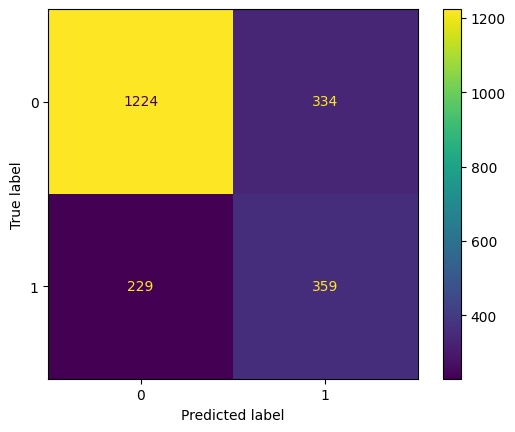


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1558
           1       0.52      0.61      0.56       588

    accuracy                           0.74      2146
   macro avg       0.68      0.70      0.69      2146
weighted avg       0.75      0.74      0.74      2146



In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_best = best_clf.predict(X_test)

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


# ---
# **Part 6: SHAP Interpretability**

100%|===================| 4291/4292 [05:32<00:00]       

<Figure size 640x480 with 0 Axes>

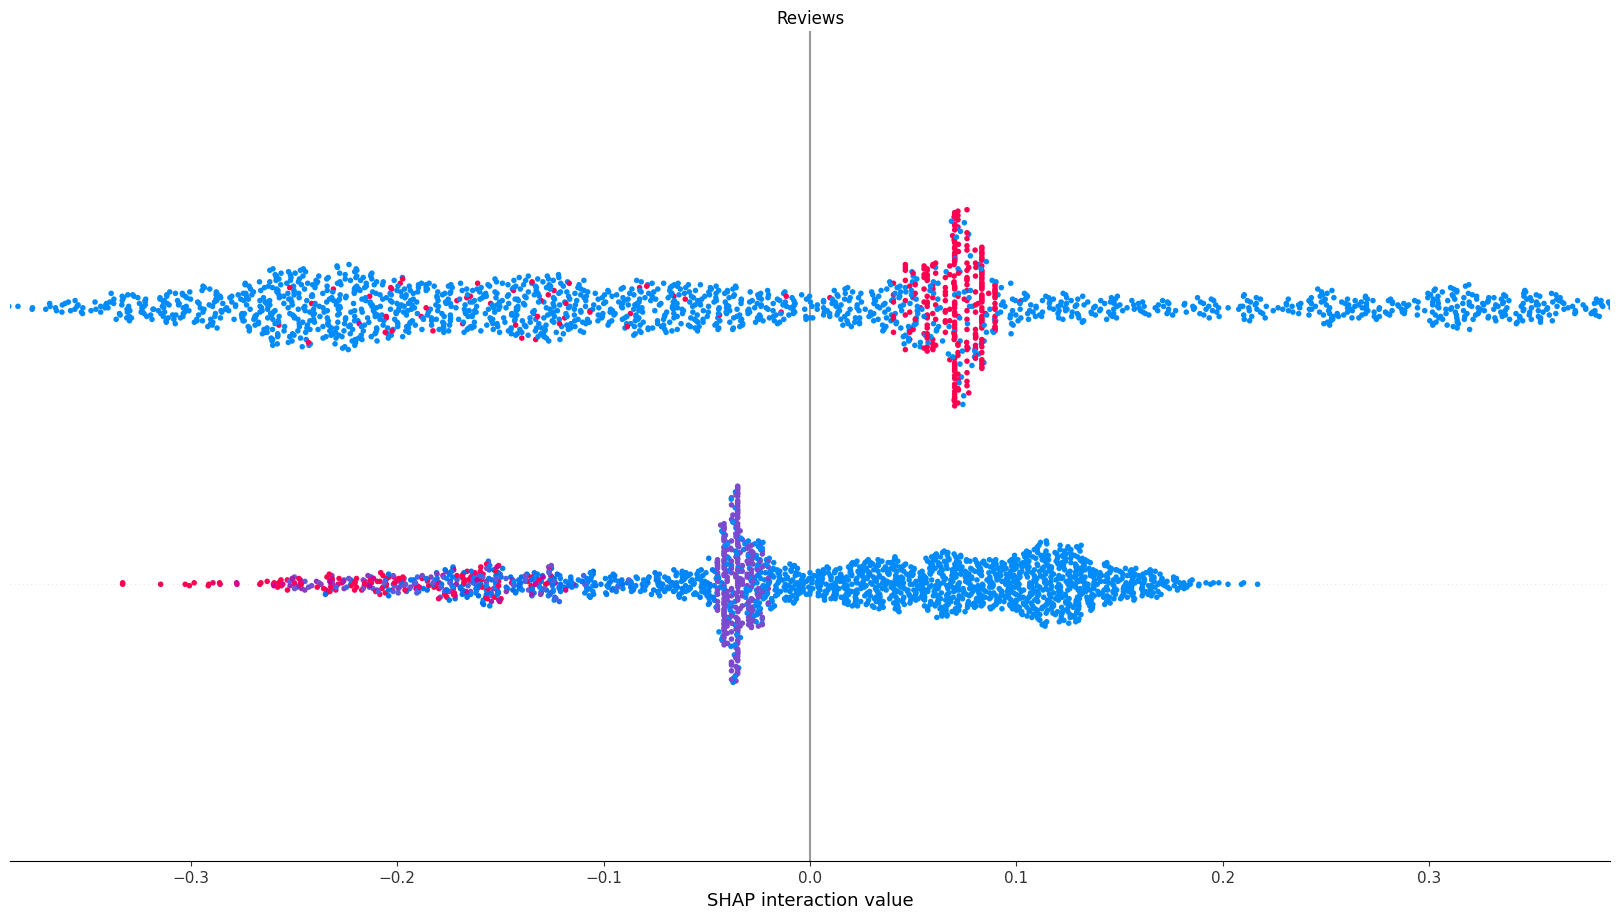

Top 10 features used in SHAP plot:
['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Engagement Score', 'Price per Review', 'PCA_1', 'PCA_2', 'PCA_3']


In [41]:
import shap
import pandas as pd

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

explainer = shap.Explainer(best_clf, X_train_df, model_output="probability")
shap_values = explainer(X_test_df)

shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=10)

print("Top 10 features used in SHAP plot:")
print(X_test_df.columns[:10].tolist())

This project applied SHAP (SHapley Additive Explanations) to interpret the predictions of our tuned `RandomForestClassifier`.

- **Explainer type**: shap.Explainer with `model_output="probability"` for classification.
- **Dataset**: We used the training set to initialize the explainer and tested on the test set.
- **Output**: A global summary bar plot showing top 10 features by mean SHAP value.

Key insights:
- Features like `Installs`, `Engagement Score`, and `Reviews` have the largest contribution to predicting whether an app is highly rated (≥ 4.5).
- Some features negatively contribute to the predicted rating probability, such as `Price`.

> SHAP helps increase model transparency and supports feature-level decision auditing.

# ---
# **Part 7: Save Model for Deployment**

In [46]:
import joblib

joblib.dump(best_clf, "best_model.pkl")

print("Model saved as best_model.pkl")

print(X.columns.tolist())

feature_means = X.mean().to_dict()
for key, value in feature_means.items():
    print(f"{key}: {value:.4f}")
import joblib

joblib.dump(X.columns.tolist(), "feature_columns.pkl")

joblib.dump(feature_means, "feature_means.pkl")

print("✅ Saved feature_columns.pkl and feature_means.pkl")




Model saved as best_model.pkl
['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Engagement Score', 'Price per Review', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']
Reviews: 0.0000
Size: 0.0000
Installs: 0.0000
Type: 0.0000
Price: 0.0000
Engagement Score: 8262528051616.4385
Price per Review: 0.0204
PCA_1: 0.0000
PCA_2: 0.0000
PCA_3: 0.0000
PCA_4: 0.0000
PCA_5: 0.0000
✅ Saved feature_columns.pkl and feature_means.pkl


In [48]:
from google.colab import files

files.download("best_model.pkl")
files.download("feature_columns.pkl")
files.download("feature_means.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>